*Grupo: Dwayne Johnson*

# Práctica de Programación Minería de textos

In [ ]:
import requests, time, json, os
from typing import List, Dict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import nltk

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Parametrización (extra)
Se puede elegir el tipo de Pokémon a elegir, por defecto será "rock", ya que este es el asignado para nuestro grupo. Si quieres usar este, puedes dejar vacía la selección.

In [ ]:
def choose_type_name(default="rock"):
  print("Introduce el tipo de Pokémon que quieres analizar (por ejemplo: rock, water, fire, grass...)")
  tipo = input(f"Tipo: ").strip().lower()

  if tipo == "":
    tipo = default  #Si no escribe nada se queda con "rock"
  return tipo


TYPE_NAME = choose_type_name()

Introduce el tipo de Pokémon que quieres analizar (por ejemplo: rock, water, fire, grass...)
Tipo: fire


## Web scrapping y acceso a APIs
Preparamos los datos que usaremos más tarde de nuestros Pokémons del tipo seleccionado.

In [ ]:
# Limitamos a Gen I y II
MAX_ID = 250
API_BASE = "https://pokeapi.co/api/v2"
CACHE_FILE = "pokeapi_cache.json"

def load_cache(path=CACHE_FILE):
    if os.path.exists(path):
        try:
            with open(path, "r") as f:
                return json.load(f)
        except Exception:
            return {}
    return {}


def save_cache(cache, path=CACHE_FILE):
    try:
        with open(path, "w") as f:
            json.dump(cache, f)
    except Exception:
        pass

CACHE = load_cache()


def get_json(url, max_retries=5, backoff=1.4, timeout=30):
    if url in CACHE:
        return CACHE[url]
    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, timeout=timeout)
            if r.status_code == 200:
                data = r.json()
                CACHE[url] = data
                # Guardamos cache de vez en cuando para no escribir en exceso
                if attempt > 1:
                    save_cache(CACHE)
                return data
            # Rate limit / temporales
            if r.status_code in (429, 500, 502, 503, 504):
                time.sleep((backoff ** attempt) + 0.2)
                continue
            r.raise_for_status()
        except Exception as e:
            last_err = e
            time.sleep((backoff ** attempt) + 0.2)
    raise RuntimeError(f"Fallo GET {url}: {last_err}")


def get_pokemon_ids_by_type(type_name: str, max_id: int = MAX_ID):
    """Devuelve lista ordenada de (id, name) para el tipo dado, filtrando id <= max_id."""
    type_url = f"{API_BASE}/type/{type_name.lower()}"
    data = get_json(type_url)
    out = []
    for entry in data["pokemon"]:
        name = entry["pokemon"]["name"]
        url = entry["pokemon"]["url"]
        try:
            poke_id = int(url.rstrip("/").split("/")[-1])
        except:
            continue
        if poke_id <= max_id:
            out.append((poke_id, name))
    out.sort(key=lambda x: x[0])
    return out


STAT_KEYS = ["hp", "attack", "defense", "special-attack"]


def parse_stats(poke_json):
  # Extrae hp, attack, defense, special-attack del JSON del Pokemón
  stats = {k: None for k in STAT_KEYS}
  for s in poke_json.get("stats", []):
    k = s.get("stat", {}).get("name")
    if k in STAT_KEYS:
      stats[k] = s.get("base_stat")
  return stats


# Tipos secundarios
def get_other_types(poke_json, primary_type: str = TYPE_NAME) -> List[str]:
  ordered_types = sorted(poke_json.get("types", []), key=lambda x: x.get("slot", 99))
  others = [
      t["type"]["name"].lower()
      for t in ordered_types
      if t["type"]["name"].lower() != primary_type.lower()
  ]
  return others


def get_primary_type(poke_json) -> str:
    """
    Devuelve el tipo primario del Pokémon (slot 1) en minúsculas.
    Si no se encuentra, cae al TYPE_NAME global.
    """
    types = poke_json.get("types", [])
    if not types:
        return TYPE_NAME.lower()
    primary = min(types, key=lambda t: t.get("slot", 99))
    return primary.get("type", {}).get("name", TYPE_NAME).lower()


def get_move_power_and_type(move_url: str):
  mjson = get_json(move_url)
  return mjson.get("power"), mjson.get("type", {}).get("name")

## Cálculo del poder

$𝑃𝑜𝑑𝑒𝑟 = \text{𝐴𝑡𝑎𝑞𝑢𝑒 𝑒𝑠𝑝𝑒𝑐𝑖𝑎𝑙}*\text{𝐷𝑎ñ𝑜 𝑏𝑎𝑠𝑒 𝑑𝑒𝑙 𝑎𝑡𝑎𝑞𝑢𝑒 𝑚á𝑠 𝑝𝑜𝑡𝑒𝑛𝑡𝑒 𝑑𝑒 𝑠𝑢 𝑡𝑖𝑝𝑜}$

In [ ]:
def compute_max_same_type_power(poke_json) -> Dict:
    """
    Busca el movimiento con mayor 'power' del MISMO TIPO PRIMARIO del Pokémon.
    Devuelve:
      {
        'primary_type': str,
        'max_same_type_power': int,
        'max_same_type_move': str | None
      }
    Si no hay movimientos con potencia válida, 'max_same_type_power' = 0.
    """
    primary_type = get_primary_type(poke_json)
    max_power = 0
    max_name = None

    for m in poke_json.get("moves", []):
        move_url = m["move"]["url"]
        try:
            power, mtype = get_move_power_and_type(move_url)
        except Exception:
            continue
        if mtype and mtype.lower() == primary_type and isinstance(power, int):
            if power > max_power:
                max_power = power
                max_name = m["move"]["name"]

    return {
        "primary_type": primary_type,
        "max_same_type_power": max_power,
        "max_same_type_move": max_name
    }

def calculate_pokemon_power(stats: Dict, power_info: Dict) -> int:
  special_attack = stats["special-attack"] or 0
  base_power = (
      power_info.get("max_same_type_power")
      or power_info.get("max_rock_power")
      or 0
  )
  return special_attack * base_power

## Equipos y gráficos

In [ ]:
# Array de pokemón tipo roca
def collect_rock_pokemon(max_id: int = MAX_ID) -> List[Dict]:
    """Recoge info completa de Pokémon roca (<= max_id)."""
    results = []
    rock_list = get_pokemon_ids_by_type(TYPE_NAME, max_id=max_id)

    for poke_id, _ in rock_list:
        pjson = get_json(f"{API_BASE}/pokemon/{poke_id}")
        name = pjson["name"]
        stats = parse_stats(pjson)
        other_types = get_other_types(pjson, TYPE_NAME)

        power_info = compute_max_same_type_power(pjson)
        power = calculate_pokemon_power(stats, power_info)


        results.append({
            "id": poke_id,
            "name": name,
            # lista de strings (puede estar vacía)
            "other_types": other_types,
            "hp": stats["hp"],
            "attack": stats["attack"],
            "defense": stats["defense"],
            "special_attack": stats["special-attack"],
            "power": power,
        })

    # Guardamos cache al final por si hubo novedades
    save_cache(CACHE)
    return results


# Filtrado de mayor a menor y mostrar los equipos
def sort_by_key_desc(items: List[Dict], key: str) -> List[Dict]:
    #Ordena desc con None al final.
    return sorted(
        items,
        key=lambda d: (
            0 if isinstance(d.get(key), int) else 1,
            -(d.get(key) if d.get(key) is not None else -10**9),
            d["id"],
        ),
    )


def print_list_offensive(items: List[Dict], stat_key: str, title: str, top_n: int = None):
    print(f"\n=== {title} ===")
    if top_n is not None:
        items = items[:top_n]
    for idx, d in enumerate(items, 1):
        tipos = ", ".join(d["other_types"]) if d["other_types"] else "—"
        print(f"{idx:>2}. #{d['id']:>3} {d['name']:<14} "
              f"(otros tipos: {tipos})  "
              f"SPA {d['special_attack']}, DEF {d['defense']}, ATK {d['attack']}, HP {d['hp']}, POW {d['power']}")


def print_list_defensive(items: List[Dict], stat_key: str, title: str, top_n: int = None):
    print(f"\n=== {title} ===")
    if top_n is not None:
        items = items[:top_n]
    for idx, d in enumerate(items, 1):
        tipos = ", ".join(d["other_types"]) if d["other_types"] else "—"
        print(f"{idx:>2}. #{d['id']:>3} {d['name']:<14} "
              f"(otros tipos: {tipos})  "
              f"DEF {d['defense']}, HP {d['hp']}, ATK {d['attack']}, SPA {d['special_attack']}")


def plot_offensive_team_power(offensive_team: List[Dict], title: str = "Poder del Equipo Ofensivo"):
    """
    Gráfico de barras mostrando el poder de cada Pokémon del equipo ofensivo.
    Poder = Special Attack × Daño base del ataque más potente.
    """
    # Tomar solo los primeros 6
    top_6 = offensive_team[:6]

    names = [p['name'].capitalize() for p in top_6]
    powers = [p['power'] for p in top_6]

    # Colores diferentes para cada barra
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

    plt.figure(figsize=(12, 7))
    bars = plt.bar(names, powers, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

    # Añadir valores encima de las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Pokémon', fontsize=13, fontweight='bold')
    plt.ylabel('Poder (Special Attack × Ataque Base)', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()


def plot_defensive_team_stats(defensive_team: List[Dict], title: str = "Estadísticas del Equipo Defensivo"):
    """
    Gráfico de barras agrupadas mostrando Defense, HP y Attack del equipo defensivo.
    """
    top_6 = defensive_team[:6]

    names = [p['name'].capitalize() for p in top_6]
    defense = [p['defense'] for p in top_6]
    hp = [p['hp'] for p in top_6]
    attack = [p['attack'] for p in top_6]

    x = np.arange(len(names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 7))

    bars1 = ax.bar(x - width, defense, width, label='Defense',
                   color='#4ECDC4', edgecolor='black', linewidth=1.2)
    bars2 = ax.bar(x, hp, width, label='HP',
                   color='#95E1D3', edgecolor='black', linewidth=1.2)
    bars3 = ax.bar(x + width, attack, width, label='Attack',
                   color='#F38181', edgecolor='black', linewidth=1.2)

    # Añadimos valores en las barras
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Pokémon', fontsize=13, fontweight='bold')
    ax.set_ylabel('Valor de Estadística', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=11)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)

    plt.tight_layout()
    plt.show()


def plot_synergy_comparison(original_team: List[Dict], boosted_team: List[Dict],
                           title: str = "Impacto de Sinergias de Tipo"):
    """
    Gráfico comparando el poder antes y después del boost de sinergias (×1.25).
    Muestra con flechas qué Pokémon recibieron el boost.
    """
    top_6_orig = original_team[:6]
    top_6_boost = boosted_team[:6]

    names = [p['name'].capitalize() for p in top_6_boost]
    original_powers = [p['power'] for p in top_6_orig]
    boosted_powers = [p['power'] for p in top_6_boost]

    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 8))

    bars1 = ax.bar(x - width/2, original_powers, width, label='Sin Sinergia',
                   color='#A8DADC', edgecolor='black', linewidth=1.2, alpha=0.9)
    bars2 = ax.bar(x + width/2, boosted_powers, width, label='Con Sinergia (×1.25)',
                   color='#457B9D', edgecolor='black', linewidth=1.2, alpha=0.9)

    # Marcar con flechas los que tienen boost
    for i, (orig, boost) in enumerate(zip(original_powers, boosted_powers)):
        if boost > orig:
            # Flecha indicando el aumento
            ax.annotate('', xy=(i + width/2, boost), xytext=(i - width/2, orig),
                       arrowprops=dict(arrowstyle='->', color='red', lw=2.5, alpha=0.7))
            # Texto del boost
            diff_percent = ((boost - orig) / orig) * 100
            ax.text(i, max(orig, boost) + 500, f'+{diff_percent:.0f}%',
                   ha='center', fontsize=10, fontweight='bold', color='red')

    # Valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}',
                   ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Pokémon', fontsize=13, fontweight='bold')
    ax.set_ylabel('Poder', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=11)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)

    plt.tight_layout()
    plt.show()


def plot_balanced_team_comparison(balanced_team: List[Dict],
                                  title: str = "Equipo Balanceado - Comparación Completa"):
    """
    Gráfico de barras múltiples comparando todas las stats del equipo balanceado.
    Muestra Special Attack, Defense, HP y Attack juntos.
    """
    names = [p['name'].capitalize() for p in balanced_team]
    sp_attack = [p['special_attack'] for p in balanced_team]
    defense = [p['defense'] for p in balanced_team]
    hp = [p['hp'] for p in balanced_team]
    attack = [p['attack'] for p in balanced_team]

    x = np.arange(len(names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(15, 8))

    bars1 = ax.bar(x - 1.5*width, sp_attack, width, label='Special Attack',
                   color='#E74C3C', edgecolor='black', linewidth=1)
    bars2 = ax.bar(x - 0.5*width, defense, width, label='Defense',
                   color='#3498DB', edgecolor='black', linewidth=1)
    bars3 = ax.bar(x + 0.5*width, hp, width, label='HP',
                   color='#2ECC71', edgecolor='black', linewidth=1)
    bars4 = ax.bar(x + 1.5*width, attack, width, label='Attack',
                   color='#F39C12', edgecolor='black', linewidth=1)

    ax.set_xlabel('Pokémon', fontsize=13, fontweight='bold')
    ax.set_ylabel('Valor de Estadística', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=11)
    ax.legend(fontsize=11, loc='upper right', ncol=2)
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)

    plt.tight_layout()
    plt.show()


def plot_balanced_team_radar(balanced_team: List[Dict],
                             title: str = "Equipo Balanceado - Gráfico Radar"):
    """
    Gráfico de radar (opcional - más visual) comparando stats del equipo balanceado.
    """
    categories = ['Special Attack', 'Defense', 'HP', 'Attack']

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

    colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C']

    for i, pokemon in enumerate(balanced_team):
        values = [
            pokemon['special_attack'],
            pokemon['defense'],
            pokemon['hp'],
            pokemon['attack']
        ]
        values += values[:1]  # Cerrar el polígono

        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        ax.plot(angles, values, 'o-', linewidth=2.5,
               label=pokemon['name'].capitalize(),
               color=colors[i % len(colors)], markersize=8)
        ax.fill(angles, values, alpha=0.15, color=colors[i % len(colors)])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    ax.set_ylim(0, max([p['defense'] for p in balanced_team] + [160]))
    ax.set_title(title, fontsize=15, fontweight='bold', pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    ax.grid(True, linewidth=0.7, alpha=0.5)

    plt.tight_layout()
    plt.show()


def display_team_as_dataframe(team: List[Dict], title: str, top_n: int = None) -> pd.DataFrame:
    """
    Muestra un equipo como DataFrame formateado y bonito.

    Args:
        team: Lista de Pokémon
        title: Título a mostrar
        top_n: Número de Pokémon a mostrar (None = todos)

    Returns:
        DataFrame con el equipo
    """
    if top_n:
        team = team[:top_n]

    # Crear DataFrame
    df_data = []
    for idx, p in enumerate(team, 1):
        otros_tipos = ", ".join(p['other_types']) if p['other_types'] else "—"

        df_data.append({
            "Rank": idx,
            "ID": f"#{p['id']}",
            "Nombre": p['name'].capitalize(),
            "Otros Tipos": otros_tipos,
            "HP": p['hp'],
            "Ataque": p['attack'],
            "Defensa": p['defense'],
            "Atq. Esp.": p['special_attack'],
            "Poder": int(p['power']) if p['power'] else 0
        })

    df = pd.DataFrame(df_data)

    # Mostrar con título
    print("\n" + "="*100)
    print(title)
    print("="*100)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 30)

    print(df.to_string(index=False))
    print("="*100)

    return df


def display_synergy_comparison_df(original_team: List[Dict],
                                  boosted_team: List[Dict],
                                  title: str,
                                  top_n: int = 6) -> pd.DataFrame:
    """
    Muestra comparación de sinergias en formato DataFrame con columnas:
    Antes/Después del boost.
    """
    original_top = original_team[:top_n]
    boosted_top = boosted_team[:top_n]

    df_data = []
    for i, (orig, boost) in enumerate(zip(original_top, boosted_top), 1):
        otros_tipos = ", ".join(boost['other_types']) if boost['other_types'] else "—"

        tiene_sinergia = boost.get('has_synergy', False)
        razon_sinergia = boost.get('synergy_reason', '—')

        cambio_poder = boost['power'] - orig['power']
        cambio_pct = ((boost['power'] - orig['power']) / orig['power'] * 100) if orig['power'] > 0 else 0

        df_data.append({
            "Rank": i,
            "Nombre": boost['name'].capitalize(),
            "Tipos Secundarios": otros_tipos,
            "Poder Original": int(orig['power']),
            "Poder Boosted": int(boost['power']),
            "Cambio": f"+{int(cambio_poder)}" if cambio_poder > 0 else "—",
            "% Cambio": f"+{cambio_pct:.1f}%" if cambio_pct > 0 else "—",
            "Sinergia": "✓" if tiene_sinergia else "✗",
            "Razón": razon_sinergia if tiene_sinergia else "—"
        })

    df = pd.DataFrame(df_data)

    print("\n" + "="*120)
    print(title)
    print("="*120)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)

    print(df.to_string(index=False))
    print("="*120)

    return df


def display_balanced_team_df(balanced_team: List[Dict], title: str) -> pd.DataFrame:
    """
    Muestra el equipo balanceado con todas sus estadísticas importantes.
    """
    df_data = []
    for idx, p in enumerate(balanced_team, 1):
        otros_tipos = ", ".join(p['other_types']) if p['other_types'] else "—"

        # Calcular score balanceado si no existe
        balance_score = p.get('balance_score',
                             p['special_attack']*0.35 + p['defense']*0.35 +
                             p['hp']*0.20 + p['attack']*0.10)

        tiene_sinergia = "Yes" if p.get('has_synergy', False) else "No"

        df_data.append({
            "Pos.": idx,
            "ID": f"#{p['id']}",
            "Nombre": p['name'].capitalize(),
            "Tipos 2º": otros_tipos,
            "HP": p['hp'],
            "ATK": p['attack'],
            "DEF": p['defense'],
            "SPA": p['special_attack'],
            "Poder": int(p['power']) if p['power'] else 0,
            "Balance": f"{balance_score:.1f}",
            "Sinergia": tiene_sinergia
        })

    df = pd.DataFrame(df_data)

    print("\n" + "="*120)
    print(title)
    print("="*120)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)

    print(df.to_string(index=False))
    print("="*120)

    # Mostrar resumen estadístico
    print("\nEstadísticas del Equipo:")
    print(f"   • HP promedio:          {df['HP'].mean():.1f}")
    print(f"   • Defensa promedio:     {df['DEF'].mean():.1f}")
    print(f"   • Atq. Esp. promedio:   {df['SPA'].mean():.1f}")
    print(f"   • Poder promedio:       {df['Poder'].mean():.1f}")
    print(f"   • Pokémon con sinergia: {df['Sinergia'].value_counts().get('✓', 0)}/{len(df)}")

    return df


def display_moves_as_dataframe(team_moves: Dict[str, List[Dict]]) -> Dict[str, pd.DataFrame]:
    """
    Muestra los movimientos de cada Pokémon en formato DataFrame.

    Returns:
        Diccionario con DataFrames por cada Pokémon
    """
    print("\n" + "="*120)
    print("MOVIMIENTOS DEL EQUIPO BALANCEADO")
    print("="*120)

    dfs = {}

    for pokemon_name, moves in team_moves.items():
        if not moves:
            print(f"\nWARN:  {pokemon_name.capitalize()}: Sin movimientos disponibles")
            continue

        print(f"\n{pokemon_name.upper()}")
        print("-" * 120)

        df_data = []
        for i, move in enumerate(moves, 1):
            efectivo_contra = ", ".join(move['super_effective_against']) if move['super_effective_against'] else "—"

            rol = "Defensivo" if move.get('is_defensive', False) else "Ofensivo"

            # Truncar descripción si es muy larga
            desc = move['description']
            desc_short = desc[:80] + "..." if len(desc) > 80 else desc

            df_data.append({
                "#": i,
                "Movimiento": move['name'],
                "Tipo": move['type'].capitalize() if move['type'] else "—",
                "Poder": move['power'] if move['power'] else "—",
                "Rol": rol,
                "Super Efectivo vs": efectivo_contra,
                "Descripción": desc_short
            })

        df = pd.DataFrame(df_data)

        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', 80)

        print(df.to_string(index=False))
        print()

        dfs[pokemon_name] = df

    print("="*120)

    return dfs


# Sinergias por tipo:
def boost_synergy_offensive_power(offensive_group: List[Dict], primary_type: str = None) -> List[Dict]:
    """
    Aplica boost ×1.25 a Pokémon con sinergias de tipo que contrarrestan
    las debilidades del tipo primario.

    Por ejemplo, para ROCA (débil a: water, grass, fighting, ground, steel):
    - Roca/Water: Water es fuerte contra ground y rock ✓
    - Roca/Fire: Fire es fuerte contra grass, ice, bug y steel ✓
    - Roca/Flying: Flying es fuerte contra grass, fighting y bug ✓
    - Roca/Ground: Ground es fuerte contra fire, electric, poison, rock y steel ✓
    """
    if primary_type is None:
        primary_type = TYPE_NAME

    # Debilidades por tipo primario (los tipos contra los que es débil)
    weaknesses = {
        "rock": ["water", "grass", "fighting", "ground", "steel"],
        "fire": ["water", "ground", "rock"],
        "water": ["electric", "grass"],
        "grass": ["fire", "ice", "poison", "flying", "bug"],
        "electric": ["ground"],
        "ice": ["fire", "fighting", "rock", "steel"],
        "fighting": ["flying", "psychic", "fairy"],
        "poison": ["ground", "psychic"],
        "ground": ["water", "grass", "ice"],
        "flying": ["electric", "ice", "rock"],
        "psychic": ["bug", "ghost", "dark"],
        "bug": ["fire", "flying", "rock"],
        "dragon": ["ice", "dragon", "fairy"],
        "ghost": ["ghost", "dark"],
        "dark": ["fighting", "bug", "fairy"],
        "steel": ["fire", "fighting", "ground"],
        "fairy": ["poison", "steel"],
        "normal": ["fighting"],
    }

    # Fortalezas: contra qué tipos es fuerte cada tipo
    strong_against = {
        "fire": ["grass", "ice", "bug", "steel"],
        "water": ["fire", "ground", "rock"],
        "grass": ["water", "ground", "rock"],
        "electric": ["water", "flying"],
        "ice": ["grass", "ground", "flying", "dragon"],
        "fighting": ["normal", "ice", "rock", "dark", "steel"],
        "poison": ["grass", "fairy"],
        "ground": ["fire", "electric", "poison", "rock", "steel"],
        "flying": ["grass", "fighting", "bug"],
        "psychic": ["fighting", "poison"],
        "bug": ["grass", "psychic", "dark"],
        "rock": ["fire", "ice", "flying", "bug"],
        "ghost": ["psychic", "ghost"],
        "dragon": ["dragon"],
        "dark": ["psychic", "ghost"],
        "steel": ["ice", "rock", "fairy"],
        "fairy": ["fighting", "dragon", "dark"],
        "normal": [],
    }

    boosted = []
    primary_weaknesses = weaknesses.get(primary_type.lower(), [])

    print(f"\nINFO: Analizando sinergias para tipo {primary_type.upper()}...")
    print(f"   Debilidades de {primary_type}: {', '.join(primary_weaknesses)}")

    for p in offensive_group:
        entry = p.copy()
        has_synergy = False
        synergy_reason = []

        # Verificar si algún tipo secundario contrarresta debilidades del primario
        for secondary_type in entry.get("other_types", []):
            secondary_strengths = strong_against.get(secondary_type.lower(), [])

            # Ver qué debilidades cubre este tipo secundario
            covered_weaknesses = [w for w in primary_weaknesses if w in secondary_strengths]

            if covered_weaknesses:
                has_synergy = True
                synergy_reason.append(f"{secondary_type} contrarresta {', '.join(covered_weaknesses)}")

        if has_synergy:
            old_power = entry["power"]
            entry["power"] = round(entry["power"] * 1.25, 2)
            entry["has_synergy"] = True
            entry["synergy_reason"] = "; ".join(synergy_reason)
            print(f"   ✓ {entry['name'].capitalize()}: {synergy_reason[0]} (poder: {old_power} → {entry['power']})")
        else:
            entry["has_synergy"] = False
            entry["synergy_reason"] = None

        boosted.append(entry)

    synergy_count = sum(1 for p in boosted if p.get("has_synergy"))
    print(f"\n   Total con sinergia: {synergy_count}/{len(boosted[:6])} del top 6")

    return boosted


# Equipo Balanceado
def build_balanced_team_dynamic(defensive_group: List[Dict],
                               offensive_group: List[Dict],
                               team_size: int = 6) -> List[Dict]:
    """
    Construye un equipo balanceado de forma DINÁMICA (sin IDs hardcodeados):

    Estrategia:
    - 2 Pokémon con mejor DEFENSA (tanques puros)
    - 2 Pokémon con mejor SPECIAL ATTACK (atacantes especiales)
    - 1 Pokémon con mejor BALANCE GENERAL (híbrido)
    - 1 Pokémon con SINERGIA (si existe) o el siguiente mejor

    Evita duplicados y prioriza diversidad.
    """
    print("\nINFO:  Construyendo equipo balanceado dinámicamente...")

    # Unificar todos los Pokémon disponibles (eliminar duplicados por ID)
    all_pokemon_dict = {}
    for p in defensive_group + offensive_group:
        if p['id'] not in all_pokemon_dict:
            all_pokemon_dict[p['id']] = p.copy()

    all_pokemon = list(all_pokemon_dict.values())

    # Calcular score balanceado para cada Pokémon
    for poke in all_pokemon:
        # Fórmula balanceada: prioriza Special Attack y Defense, considera HP
        poke['balance_score'] = (
            poke['special_attack'] * 0.35 +
            poke['defense'] * 0.35 +
            poke['hp'] * 0.20 +
            poke['attack'] * 0.10
        )

    team = []
    used_ids = set()

    # eleccionar 2 mejores tanques (defensores)
    print("\n   Seleccionando defensores...")
    by_defense = sorted(all_pokemon, key=lambda p: (p['defense'], p['hp']), reverse=True)

    for p in by_defense:
        if p['id'] not in used_ids:
            team.append(p.copy())
            used_ids.add(p['id'])
            print(f"   ✓ Defensor: {p['name'].capitalize()} (DEF: {p['defense']}, HP: {p['hp']})")
        if len(team) >= 2:
            break

    # Seleccionar 2 con mejores ataq. especiales
    print("\n   Seleccionando atacantes especiales...")
    by_spattack = sorted(all_pokemon, key=lambda p: (p['special_attack'], p['power']), reverse=True)

    for p in by_spattack:
        if p['id'] not in used_ids:
            team.append(p.copy())
            used_ids.add(p['id'])
            print(f"   ✓ Atacante: {p['name'].capitalize()} (SPA: {p['special_attack']}, POW: {p['power']})")
        if len(team) >= 4:
            break

    # Seleccionar uno balanceado (híbrido)
    print("\n   Seleccionando híbrido balanceado...")
    by_balance = sorted(all_pokemon, key=lambda p: p['balance_score'], reverse=True)

    for p in by_balance:
        if p['id'] not in used_ids:
            team.append(p.copy())
            used_ids.add(p['id'])
            print(f"   ✓ Híbrido: {p['name'].capitalize()} (Balance score: {p['balance_score']:.1f})")
            break

    # Seleccionar unno con SINERGIA (si existe) o el siguiente mejor
    print("\n   Seleccionando Pokémon con sinergia o mejor disponible...")

    # Priorizar los que tienen sinergia
    with_synergy = sorted(
        [p for p in all_pokemon if p.get('has_synergy', False) and p['id'] not in used_ids],
        key=lambda p: p['power'],
        reverse=True
    )

    if with_synergy:
        p = with_synergy[0]
        team.append(p.copy())
        used_ids.add(p['id'])
        print(f"   ✓ Sinergia: {p['name'].capitalize()} ({p.get('synergy_reason', 'N/A')})")
    else:
        # Si no hay con sinergia, tomar el mejor disponible por balance
        for p in by_balance:
            if p['id'] not in used_ids:
                team.append(p.copy())
                used_ids.add(p['id'])
                print(f"   ✓ Mejor disponible: {p['name'].capitalize()}")
                break

    # Rellenar si faltan (por si acaso)
    while len(team) < team_size:
        for p in by_balance:
            if p['id'] not in used_ids:
                team.append(p.copy())
                used_ids.add(p['id'])
                break

    # Ordenar el equipo final por Special Attack para presentación
    team_sorted = sorted(team, key=lambda x: x['special_attack'], reverse=True)

    print(f"\n\t Equipo de {len(team_sorted)} Pokémon construido")

    return team_sorted


def print_balanced_team(balanced_team: List[Dict], title: str):
  print(f"\n=== {title} ===")
  for idx, p in enumerate(balanced_team, 1):
      tipos = ", ".join(p["other_types"]) if p["other_types"] else "—"
      print(f"{idx}. #{p['id']} {p['name']}  "
            f"(otros tipos: {tipos})  "
            f"SPA {p['special_attack']}, DEF {p['defense']}, HP {p['hp']} "
            f"ATK {p['attack']}, POW {p.get('power','-')}")

## NLP

In [ ]:
lemmatizer = WordNetLemmatizer()
EN_STOPWORDS = set(stopwords.words("english"))


def _get_wordnet_pos(treebank_tag: str):
  if treebank_tag.startswith("J"):
        return wordnet.ADJ
  if treebank_tag.startswith("V"):
        return wordnet.VERB
  if treebank_tag.startswith("N"):
        return wordnet.NOUN
  if treebank_tag.startswith("R"):
        return wordnet.ADV
  return wordnet.NOUN

DEFENSIVE_LEMMAS = {
    # defensa / escudo / protección
    "protect", "guard", "shield", "defend", "barrier", "wall",
    "screen", "safeguard", "substitute", "reflect",
    # reducir daño / stats del rival / aumentar los tuyos
    "reduce", "lower", "decrease", "cut",
    "increase", "boost", "raise", "sharply", "greatly",
    "resist", "resistance",
    # curación
    "heal", "cure", "restore", "recover", "recovery", "drain"
}


def defensive_attack(descripcion: str) -> bool:
    """
    Clasifica si un ataque es defensivo o no a partir de su descripción
    de texto. Devuelve True si se considera defensivo, False en caso contrario.
    """
    if not descripcion:
        return False

    tokens = word_tokenize(descripcion.lower())

    # Filtramos tokens no alfabéticos y stopwords
    tokens = [t for t in tokens if t.isalpha() and t not in EN_STOPWORDS]
    if not tokens:
        return False

    tagged = pos_tag(tokens)

    # Lematización usando la etiqueta gramatical
    lemmas = []
    for word, tag in tagged:
        wn_pos = _get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=wn_pos)
        lemmas.append(lemma)

    for lemma in lemmas:
        if lemma in DEFENSIVE_LEMMAS:
            return True

    return False


def description_attack_classification(descripcion: str) -> str:
    """
    Devuelve una etiqueta de texto a partir de la función anterior:
    'defensivo' o 'ofensivo'.
    """
    return "defensivo" if defensive_attack(descripcion) else "ofensivo"

## Web scrapping
Para coger ataques desde PokemonDB.

In [ ]:
BASE_POKEDEX_URL = "https://pokemondb.net/pokedex/"
BASE_MOVES_URL = "https://pokemondb.net"
MOVE_CACHE: Dict[str, Dict] = {}

# Tipos objetivo a debilitar fuertemente
TARGET_TYPES = ["water", "grass", "fighting", "ground", "steel"]

# Tabla reducida de efectividades: tipo del movimiento -> contra qué tipos objetivo es súper eficaz
SUPER_EFFECTIVE_VS_TARGETS = {
    "electric": ["water"],
    "grass":    ["water", "ground"],
    "fire":     ["grass", "steel"],
    "ice":      ["grass", "ground"],
    "poison":   ["grass"],
    "flying":   ["grass", "fighting"],
    "bug":      ["grass"],
    "psychic":  ["fighting"],
    "fairy":    ["fighting"],
    "water":    ["ground"],
    "ground":   ["steel"],
    "fighting": ["steel"],
}


def get_move_type_and_power(move_rel_url: str) -> Dict:
    url = BASE_MOVES_URL + move_rel_url
    if url in MOVE_CACHE:
        return MOVE_CACHE[url]

    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    move_type = None
    power = None
    description = ""

    table = soup.select_one("table.vitals-table")
    if table:
        for row in table.select("tr"):
            th = row.find("th")
            td = row.find("td")
            if not th or not td:
                continue
            label = th.get_text(strip=True).lower()
            value = td.get_text(strip=True)

            if label == "type":
                move_type = value.lower()
            elif label == "power":
                # Algunos movimientos tienen "—" en vez de número
                value_clean = value.replace("—", "").strip()
                if value_clean.isdigit():
                    power = int(value_clean)

    main = soup.select_one("main")
    p = None
    if main:
        h1 = main.find("h1")
        if h1:
            p = h1.find_next("p")
        if not p:
            p = main.find("p")
    if not p:
        p = soup.find("p")

    if p:
        description = p.get_text(strip=True)

    info = {"type": move_type, "power": power, "description": description}
    MOVE_CACHE[url] = info
    return info

## Calculo de mejores movimientos para nuestro equipo

In [ ]:
def coverage_score(move_type: str) -> int:
    """
    Devuelve cuántos de los tipos objetivo (water, grass, fighting, ground, steel)
    golpea de forma súper eficaz el tipo del movimiento.
    """
    if move_type is None:
        return 0
    return len(SUPER_EFFECTIVE_VS_TARGETS.get(move_type.lower(), []))


def get_best_moves_for_targets(pokemon_name: str, max_moves: int = 4) -> List[Dict]:
    """
    Desde la página de Pokédex de PokemonDB, obtiene TODOS los movimientos del Pokémon,
    calcula cuáles cubren mejor los tipos objetivo (agua/planta/lucha/tierra/acero)
    y devuelve una lista con los 'max_moves' mejores nombres de movimientos.
    """
    url = BASE_POKEDEX_URL + pokemon_name.lower()
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    moves_info: Dict[str, Dict] = {}

    # Recorremos todas las tablas de movimientos que tengan columna "Move"
    for table in soup.select("table.data-table"):
        headers = [th.get_text(strip=True).lower() for th in table.select("thead th")]
        if "move" not in headers:
            continue

        move_idx = headers.index("move")

        for row in table.select("tbody tr"):
            cols = row.find_all("td")
            if not cols or move_idx >= len(cols):
                continue

            link = cols[move_idx].find("a")
            if not link:
                continue

            move_name = link.get_text(strip=True)
            move_rel_url = link.get("href", "")

            if not move_name or not move_rel_url:
                continue

            # Evitar duplicados (el mismo movimiento en varias tablas)
            if move_name in moves_info:
                continue

            detail = get_move_type_and_power(move_rel_url)

            move_type = detail["type"]
            power = detail["power"]
            description = detail.get("description", "")
            if power is None:
              continue

            moves_info[move_name] = {
                "name": move_name,
                "type": move_type,
                "power": power,
                "description": description,
                "super_effective_against": SUPER_EFFECTIVE_VS_TARGETS.get(move_type, []),
                "is_defensive": defensive_attack(description),
                "defense_label": description_attack_classification(description)
            }

    if not moves_info:
        return []

    # Ordenar por cobertura y potencia
    best_moves = select_best_defensive_moves(moves_info, max_moves=max_moves)

    best_moves.sort(
        key=lambda m: (len(m["super_effective_against"]), m["power"]),
        reverse=True
    )

    return best_moves[:max_moves]


def select_best_defensive_moves(moves_info: Dict[str, Dict], max_moves: int = 4) -> List[Dict]:
  if not moves_info:
        return []

    # Transformamos a lista
  all_moves = list(moves_info.values())

    # Separamos por rol
  defensive_moves = [m for m in all_moves if m.get("is_defensive")]
  offensive_moves = [m for m in all_moves if not m.get("is_defensive")]

    # Misma lógica de orden que tenías: primero cobertura, luego potencia
  def score(m):
      return (len(m.get("super_effective_against", [])), m.get("power") or 0)

  defensive_moves.sort(key=score, reverse=True)
  offensive_moves.sort(key=score, reverse=True)

  selected: List[Dict] = []

    # Intentamos meter al menos 1 movimiento defensivo si existe
  if defensive_moves:
      selected.append(defensive_moves[0])

  # Rellenar el resto de huecos con los mejores ofensivos
  for m in offensive_moves:
      if len(selected) >= max_moves:
          break
      selected.append(m)

  # Si aún sobran huecos, rellenamos con más defensivos
  if len(selected) < max_moves:
      for m in defensive_moves[1:]:
          if len(selected) >= max_moves:
              break
          selected.append(m)

  # Devolver sólo hasta max_moves
  return selected[:max_moves]


def get_team_best_moves(balanced_team: List[Dict]) -> Dict[str, List[str]]:
    """
    Para cada Pokémon del equipo balanceado, obtiene sus 4 mejores movimientos
    para debilitar fuertemente a los tipos agua/planta/lucha/tierra/acero.
    Devuelve un diccionario: nombre -> lista de movimientos.
    """
    team_moves = {}

    for member in balanced_team:
        name = member["name"]
        try:
            team_moves[name] = get_best_moves_for_targets(name, max_moves=4)
        except Exception as e:
            print(f"  [Aviso] No se pudieron obtener buenos movimientos para {name}: {e}")
            team_moves[name] = []

    return team_moves


def print_team_moves(team_moves: Dict[str, List[str]]):
  print("\n=== ATAQUES DEL EQUIPO BALANCEADO ===")
  for pokemon, moves in team_moves.items():
    print(f"\n{pokemon}:")
    if not moves:
      print(" (Sin movimientos disponibles)")
    else:
      for m in moves:
        effective = ", ".join(m["super_effective_against"]) if m["super_effective_against"] else "—"
        etiqueta = m.get("defense_label", "ofensivo")
        print(f"  - {m['name']}  --> Tipo: {m['type']} | Power: {m['power']} | Super eficaz contra: {effective} | Rol: {etiqueta}")
        print(f"    Descripción: {m['description']}")
        print()

## Main del programa!

ANÁLISIS POKÉMON TIPO FIRE

INFO: Recolectando datos de la API...
INFO: 22 Pokémon tipo fire encontrados (Gen I-II)

Equipo Defensivo - Tipo Fire
 Rank   ID    Nombre Otros Tipos  HP  Ataque  Defensa  Atq. Esp.  Poder
    1 #219  Magcargo        rock  60      50      120         90  11700
    2 #146   Moltres      flying  90     100       90        125  16250
    3 #250     Ho-oh      flying 106     130       90        110  14300
    4 #244     Entei           — 115     115       85         90  13500
    5  #59  Arcanine           —  90     110       80        100  13000
    6   #6 Charizard      flying  78      84       78        109  16350


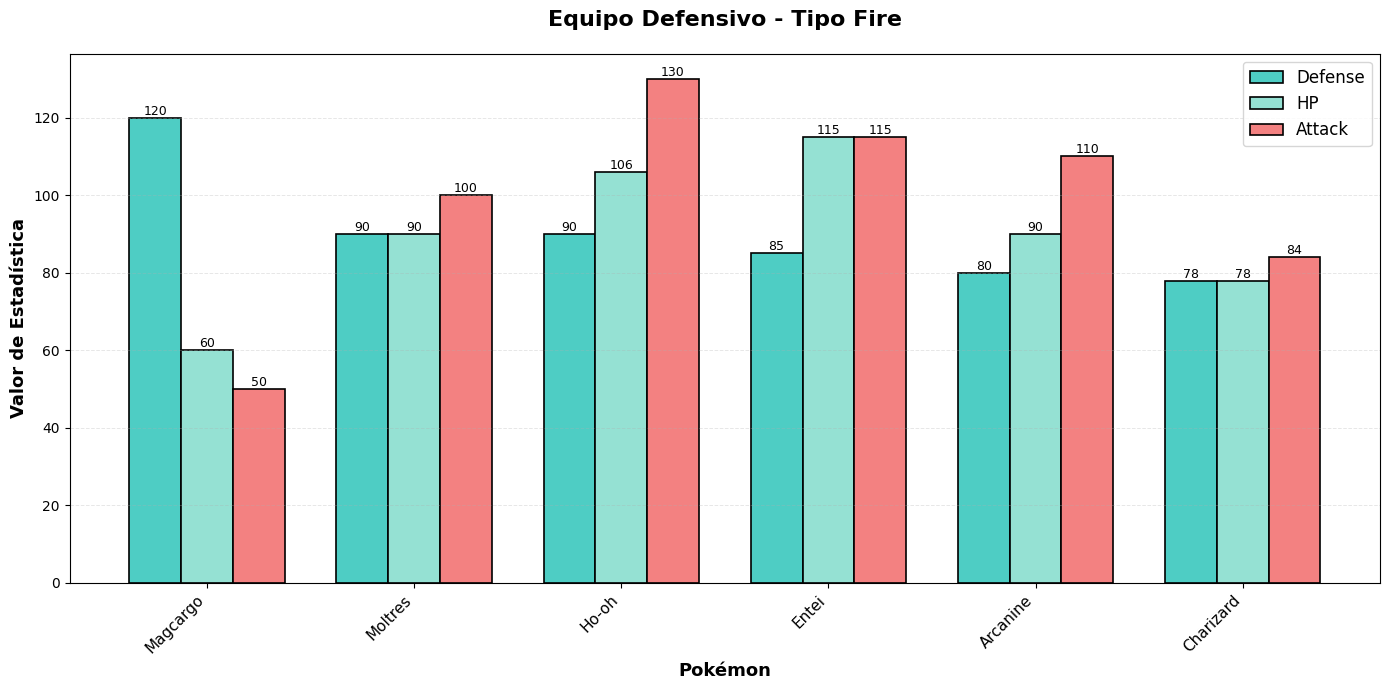


Equipo Ofensivo (Base) - Tipo Fire
 Rank   ID     Nombre Otros Tipos  HP  Ataque  Defensa  Atq. Esp.  Poder
    1 #146    Moltres      flying  90     100       90        125  16250
    2 #229   Houndoom        dark  75      90       50        110  10450
    3 #250      Ho-oh      flying 106     130       90        110  14300
    4   #6  Charizard      flying  78      84       78        109  16350
    5 #157 Typhlosion           —  78      84       78        109  16350
    6  #59   Arcanine           —  90     110       80        100  13000


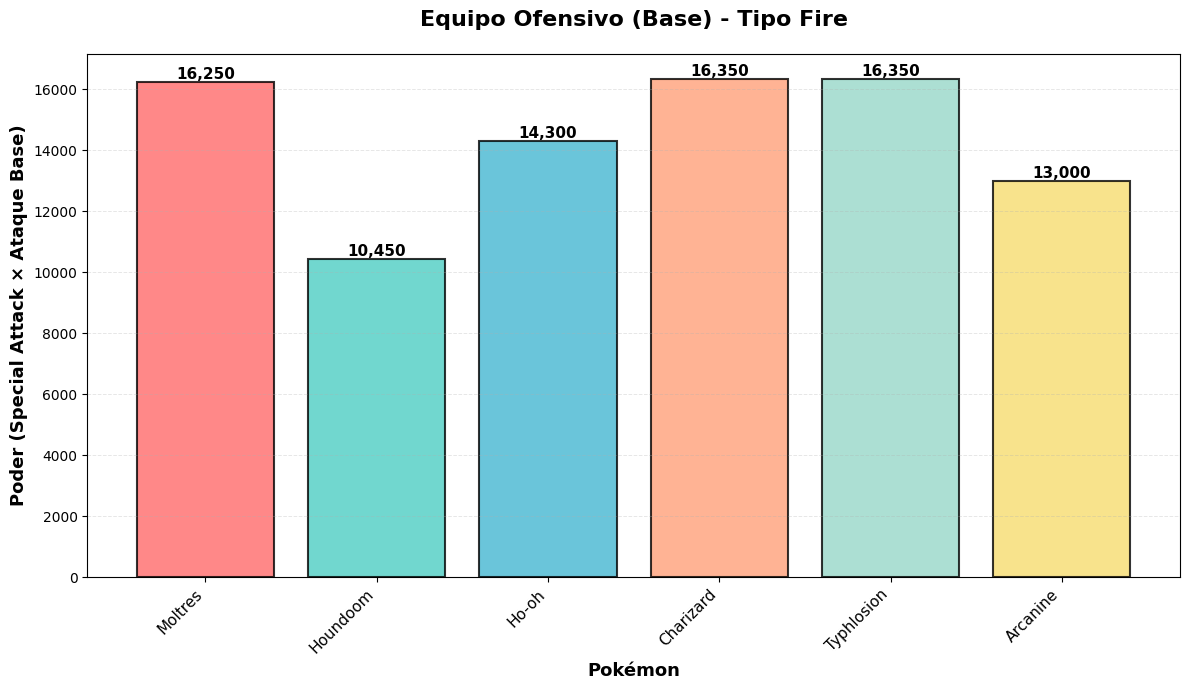


INFO: Analizando sinergias para tipo FIRE...
   Debilidades de fire: water, ground, rock

   Total con sinergia: 0/6 del top 6

Análisis de Sinergias - Tipo Fire
 Rank     Nombre Tipos Secundarios  Poder Original  Poder Boosted Cambio % Cambio Sinergia Razón
    1    Moltres            flying           16250          16250      —        —        ✗     —
    2   Houndoom              dark           10450          10450      —        —        ✗     —
    3      Ho-oh            flying           14300          14300      —        —        ✗     —
    4  Charizard            flying           16350          16350      —        —        ✗     —
    5 Typhlosion                 —           16350          16350      —        —        ✗     —
    6   Arcanine                 —           13000          13000      —        —        ✗     —


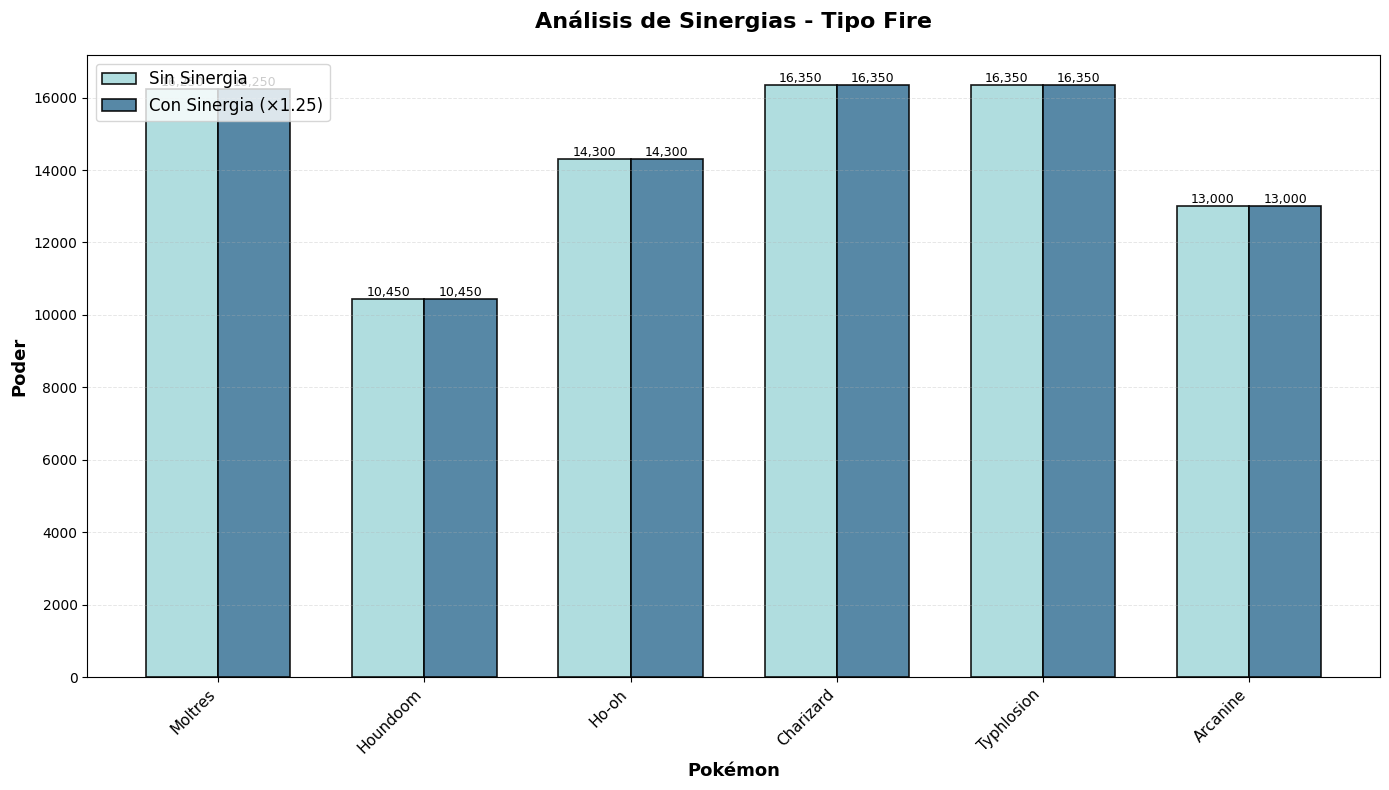


INFO:  Construyendo equipo balanceado dinámicamente...

   Seleccionando defensores...
   ✓ Defensor: Magcargo (DEF: 120, HP: 60)
   ✓ Defensor: Ho-oh (DEF: 90, HP: 106)

   Seleccionando atacantes especiales...
   ✓ Atacante: Moltres (SPA: 125, POW: 16250)
   ✓ Atacante: Houndoom (SPA: 110, POW: 10450)

   Seleccionando híbrido balanceado...
   ✓ Híbrido: Entei (Balance score: 95.8)

   Seleccionando Pokémon con sinergia o mejor disponible...
   ✓ Mejor disponible: Arcanine

	 Equipo de 6 Pokémon construido

Equipo Balanceado Final - Tipo Fire
 Pos.   ID   Nombre Tipos 2º  HP  ATK  DEF  SPA  Poder Balance Sinergia
    1 #146  Moltres   flying  90  100   90  125  16250   103.2       No
    2 #250    Ho-oh   flying 106  130   90  110  14300   104.2       No
    3 #229 Houndoom     dark  75   90   50  110  10450    80.0       No
    4  #59 Arcanine        —  90  110   80  100  13000    92.0       No
    5 #219 Magcargo     rock  60   50  120   90  11700    90.5       No
    6 #244    En

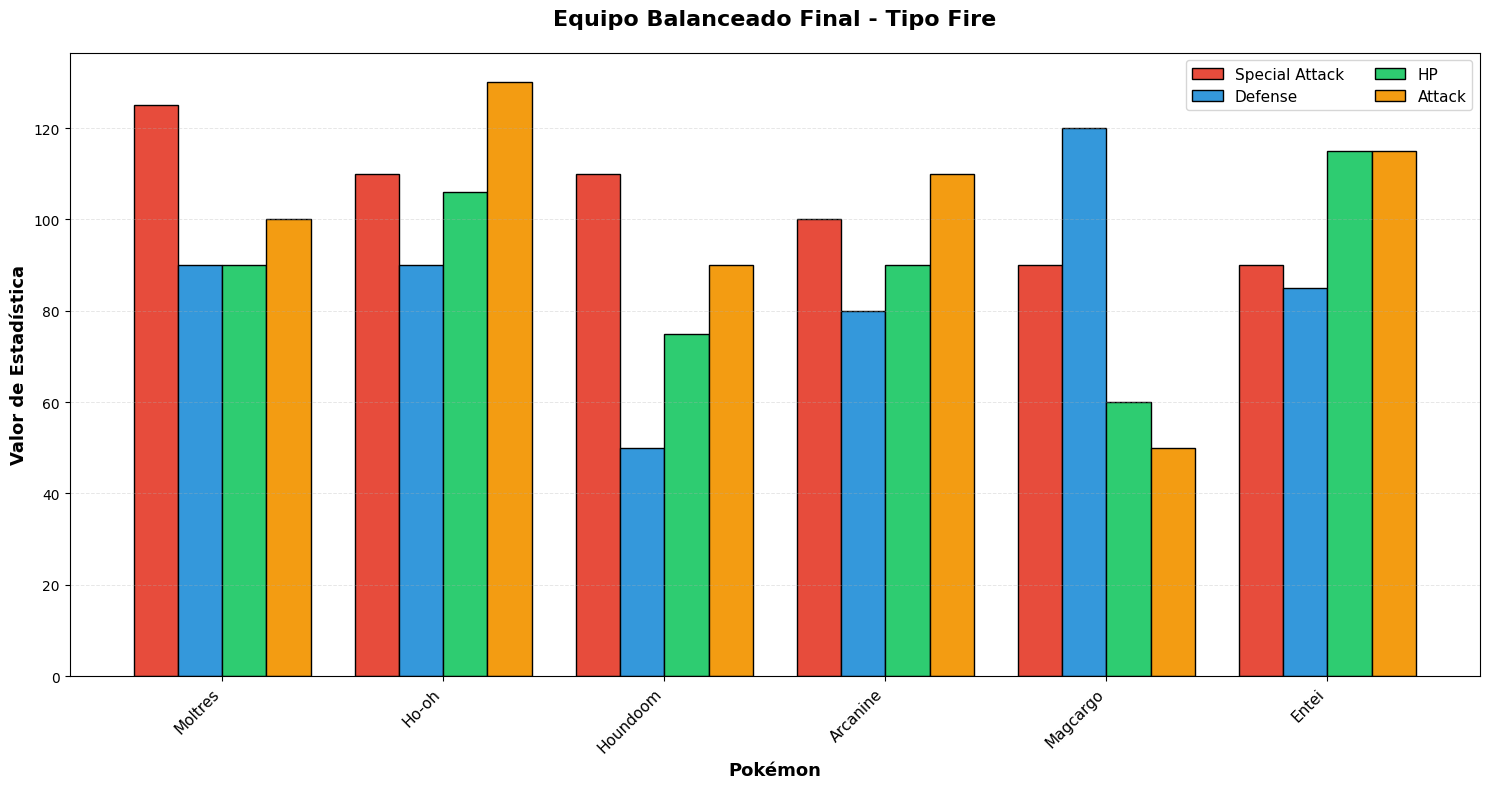



Analizando movimientos del equipo...

MOVIMIENTOS DEL EQUIPO BALANCEADO

MOLTRES
------------------------------------------------------------------------------------------------------------------------
 #  Movimiento   Tipo  Poder       Rol Super Efectivo vs                                                                         Descripción
 1  Sky Attack Flying    140  Ofensivo   grass, fighting The user ofSky Attackwillbecome cloaked in a harsh lighton the first turn. On th...
 2    Overheat   Fire    130 Defensivo      grass, steel Overheatdeals damage but lowers the user's Special Attack by two stages after at...
 3  Brave Bird Flying    120  Ofensivo   grass, fighting Brave Birddeals damage, but the user receives1⁄3of the damage it inflicted in re...
 4 Flare Blitz   Fire    120  Ofensivo      grass, steel Flare Blitzdeals damage and has a 10% chance of burning the target, but the user...


HO-OH
-----------------------------------------------------------------------------------

In [ ]:
if __name__ == "__main__":
    print("="*100)
    print(f"ANÁLISIS POKÉMON TIPO {TYPE_NAME.upper()}")
    print("="*100)

    # Recolectar datos
    print("\nINFO: Recolectando datos de la API...")
    data = collect_rock_pokemon(MAX_ID)
    print(f"INFO: {len(data)} Pokémon tipo {TYPE_NAME} encontrados (Gen I-II)")

    # Ordenar por stats
    offensive_team = sort_by_key_desc(data, "special_attack")
    defensive_team = sort_by_key_desc(data, "defense")

    # Equipo defensivo
    title_def = f"Equipo Defensivo - Tipo {TYPE_NAME.capitalize()}"
    df_defensive = display_team_as_dataframe(defensive_team, title_def, top_n=6)
    plot_defensive_team_stats(defensive_team, title_def)

    # Equipo ofensivo
    title_off = f"Equipo Ofensivo (Base) - Tipo {TYPE_NAME.capitalize()}"
    df_offensive = display_team_as_dataframe(offensive_team, title_off, top_n=6)
    plot_offensive_team_power(offensive_team, title_off)

    # Sinergias
    final_offensive_team = boost_synergy_offensive_power(offensive_team, TYPE_NAME)
    title_synergy = f"Análisis de Sinergias - Tipo {TYPE_NAME.capitalize()}"
    df_synergy = display_synergy_comparison_df(offensive_team, final_offensive_team,
                                               title_synergy, top_n=6)
    plot_synergy_comparison(offensive_team, final_offensive_team, title_synergy)

    # Equipo balanceado
    balanced_team = build_balanced_team_dynamic(defensive_team, final_offensive_team)
    title_bal = f"Equipo Balanceado Final - Tipo {TYPE_NAME.capitalize()}"
    df_balanced = display_balanced_team_df(balanced_team, title_bal)
    plot_balanced_team_comparison(balanced_team, title_bal)

    # Mejores movimientos para el equipo
    print("\n\nAnalizando movimientos del equipo...")
    team_best_moves = get_team_best_moves(balanced_team)
    dfs_moves = display_moves_as_dataframe(team_best_moves)
